In [1]:
import numpy as np
import pandas as pd
from scipy import stats

import statsmodels.api as sm
import seaborn as sns
from statsmodels.stats.multitest import multipletests

%pylab inline

Populating the interactive namespace from numpy and matplotlib


Описание датасета:

* LIMIT_BAL:  размер кредитного лимита (в том числе и на семью клиента)

* SEX: пол клиента (1 = мужской, 2 = женский )

* EDUCATION: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5= прочее; 6 = нет данных ).

* MARRIAGE: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных). 

* AGE: возраст в годах

* PAY_0 - PAY_6 : История прошлых платежей по кредиту. PAY_6 - платеж в апреле, ... Pay_0 - платеж в сентябре. Платеж = (0 = исправный платеж, 1=задержка в один месяц, 2=задержка в 2 месяца ...)

* BILL_AMT1 - BILL_AMT6:  задолженность,  BILL_AMT6 - на апрель, BILL_AMT1 - на сентябрь 

* PAY_AMT1 - PAY_AMT6: сумма уплаченная в PAY_AMT6 - апреле, ..., PAY_AMT1 - сентябре 

* default - индикатор невозврата денежных средств

Задача: изучить статистическую и практическую значимость признаков по отношению к default.  Загрузим данные и оставим только интересующие признаки.

In [4]:
df = pd.read_csv('credit_card_default_analysis.csv')
print(df.shape)
data = df[['LIMIT_BAL','SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'default']]

(30000, 25)


In [5]:
data.head(5)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,default
0,20000,2,2,1,24,1
1,120000,2,2,2,26,1
2,90000,2,2,2,34,0
3,50000,2,2,1,37,0
4,50000,1,2,1,57,0


In [4]:
data['default'].value_counts()

0    23364
1     6636
Name: default, dtype: int64

### Признак LIMIT_BAL

Взглянем на признак LIMIT_BAL в каждой из групп default:

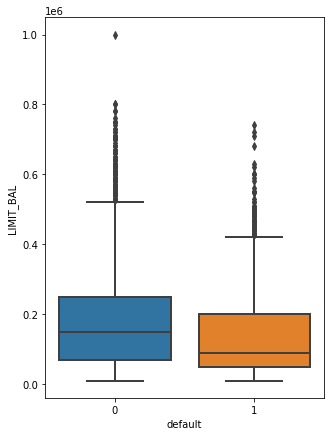

In [5]:
plt.figure(figsize=(5,7))
sns.boxplot(x=data['default'], y=data['LIMIT_BAL'], linewidth=2)
plt.show()

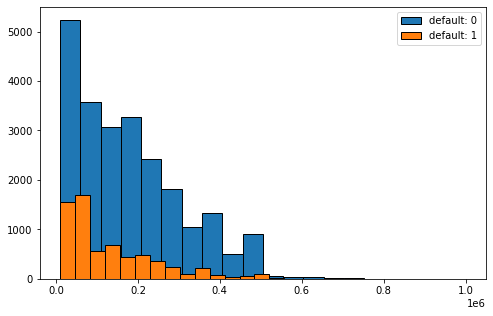

In [6]:
plt.figure(figsize=(8,5))
plt.hist(data[data['default'] == 0]['LIMIT_BAL'], bins=20, label='default: 0', edgecolor='k')
plt.hist(data[data['default'] == 1]['LIMIT_BAL'], bins=20, label='default: 1', edgecolor='k', color='tab:orange')
plt.legend()
plt.show()


Нас интересуют медианные значения. Исходя из графиков, мы видим, что скорее всего медианные значения отличаются. На boxplot выборочные медианы отличны, на гистограме распределения у признака с default 0 имеется более тяжелый хвост, нежели у признака с default 1. 

Построим доверительные интервалы для медиан с помощью бутстрепа:

In [40]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries


no_def_lb = data[data['default'] == 0]['LIMIT_BAL'].values
with_def_lb = data[data['default'] == 1]['LIMIT_BAL'].values

np.random.seed(0)

no_def_lb_scores = list(map(np.median, get_bootstrap_samples(no_def_lb, 10000)))
with_def_lb_scores = list(map(np.median, get_bootstrap_samples(with_def_lb, 10000)))

In [41]:
print('95% доверительный интервал для медианы выборки с default 0: ', stat_intervals(no_def_lb_scores, 0.05))
print('95% доверительный интервал для медианы выборки с default 1: ', stat_intervals(with_def_lb_scores, 0.05))

95% доверительный интервал для медианы выборки с default 0:  [150000. 150000.]
95% доверительный интервал для медианы выборки с default 1:  [80000. 90000.]


Точечные выборочные оценки:

In [9]:
print('Оценка медианы выборки с default 0: ', np.median(no_def_lb))
print('Оценка медианы выборки с default 1: ', np.median(with_def_lb))
print('Оценка разности медиан: ', np.median(no_def_lb)-np.median(with_def_lb))

Оценка медианы выборки с default 0:  150000.0
Оценка медианы выборки с default 1:  90000.0
Оценка разности медиан:  60000.0


Интервальная оценка разности медиан:

In [42]:
delta_median_scores = list(map(lambda x: x[0] - x[1], zip(no_def_lb_scores, with_def_lb_scores)))
print('95% доверительный интервал для разности медиан: ',  stat_intervals(delta_median_scores, 0.05))

95% доверительный интервал для разности медиан:  [60000. 70000.]


Доверительный интервал не содержит нуля, поэтому разность статистически значимая. 

Проверим гипотезу о равенстве средних с помощью непараметрического критерия Манни-Уитни.

H0: распределения выборок полностью равны,
H1: распределения выборок отличаются на величину сдвига.

In [11]:
stats.mannwhitneyu(no_def_lb, with_def_lb)

MannwhitneyuResult(statistic=59257217.5, pvalue=6.127742909111652e-190)

p-value чрезвычайно мало, поэтому мы уверенно отвергаем нулевую гипотезу о равенстве распределения в пользу альтернативной.

Таким образом, люди, которые не возвращают долг, обычно получают меньшую сумму денег. Полученные результаты значимы с практической точки зрения, поскольку разница между медианами существенная. 

### Признак SEX

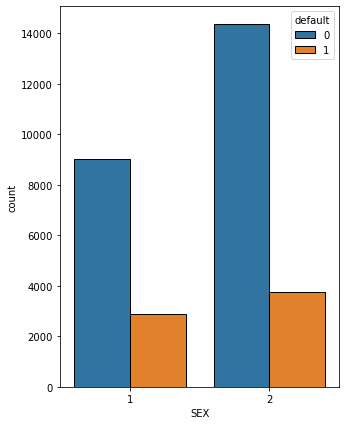

In [12]:
plt.figure(figsize=(5,7))
sns.countplot(x=data['SEX'], hue=data['default'], edgecolor='k')
plt.show()

Проверим, что гендерный состав группы людей вернувших и не вернувших кредит отличается. Будем использовать двустороннюю альтернативу, поскольку у нас нет ожиданий касательно распределения долей вернувших долг в зависимости от пола. 

Нулевая гипотеза H0:  гендерный состав вернувших и не вернувших кредит не отличается.

Нулевая гипотеза H1:  гендерный состав вернувших и не вернувших кредит отличается.



Для начала пострим доверительные интервалы для долей. Поскольку у нас доли не экстремальные, можно воспользоваться критерием для долей на основе нормального распределения. 

In [13]:
men = data[data['SEX'] == 1]['default']
women = df[df['SEX'] == 2]['default']

In [14]:
from statsmodels.stats.proportion import proportion_confint

normal_interval_m =  proportion_confint(men.sum(), len(men), alpha=0.05, method='normal')
normal_interval_w =  proportion_confint(women.sum(), len(women), alpha=0.05, method='normal')

In [15]:
print('95% доверительные интервалы для доли мужчин, не вернувших кредит: ', normal_interval_m)
print('95% доверительные интервалы для доли женщин, не вернувших кредит: ', normal_interval_w)

95% доверительные интервалы для доли мужчин, не вернувших кредит:  (0.23397679702375163, 0.2493677521014166)
95% доверительные интервалы для доли женщин, не вернувших кредит:  (0.20185432056295824, 0.21367129781160007)


Интервалы не пересекаются.  Таким образом, различие в проценте вернувших кредит в зависимости от пола значимо. Воспользуемся z-критерием для разностей долей для независимых выборок:

In [16]:
def proportions_diff_confint_ind(a, n1, b, n2, alpha = 0.05):    
    z = stats.norm.ppf(1 - alpha / 2.)
    
    p1 = float(a) / n1
    p2 = float(b) / n2
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ n1 + p2 * (1 - p2)/ n2)
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ n1 + p2 * (1 - p2)/ n2)
    
    return (left_boundary, right_boundary)

def proportions_diff_z_stat_ind(a, n1, b, n2):   
    
    p1 = float(a) / n1
    p2 = float(b) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

def pvalue_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - stats.norm.cdf(z_stat)



Построим доверительный интервал для разности долей:

In [17]:
print('95% доверительные интервалы для разности долей: ', proportions_diff_confint_ind(men.sum(), len(men), women.sum(), len(women)))

95% доверительные интервалы для разности долей:  (0.024207372179792706, 0.0436115585708172)


Интервал не содержит нуля. Найдем z-статистику и построим по ней p-value. 

In [18]:
z_stat = proportions_diff_z_stat_ind(men.sum(), len(men), women.sum(), len(women))
print('p_value: ', pvalue_z_test(z_stat))

p_value:  4.472866521609831e-12


Таким образом, на уровне значимости 0.05 (даже на 0.001)  мы уверенно отвергаем нулевую гипотезе об отсутствии различий в долях по гендерному признаку. Мы видим, что доля мужчин, которые не возвращают кредит, выше нежели доля женщин. Разница находится в 95% доверительном интервале (0.024, 0.044). Данное различие практически значимо (2-4% для банка существенная величина).

### Признак EDUCATION

Посмотрим на число элементов в выборке, соответствующих каждой ступени образования.

In [19]:
print(data['EDUCATION'].value_counts())

2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: EDUCATION, dtype: int64


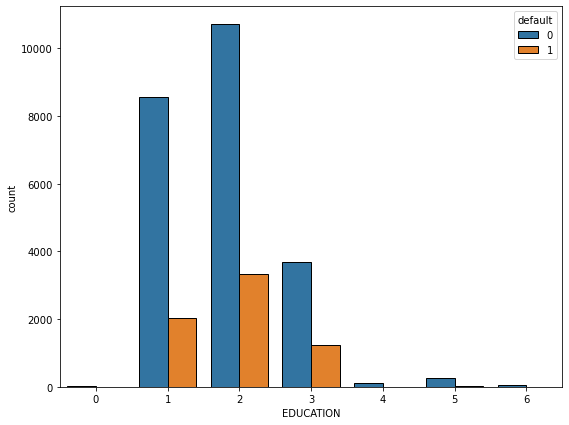

In [20]:
plt.figure(figsize=(9,7))
sns.countplot(x=data['EDUCATION'], hue=data['default'], edgecolor='k')
plt.show()

Посчитаем доли вернувших кредит людей по различным ступеням образования. Ожидаем, что такая доля будет иметь равномерное распределение, что означало бы отутствие какой либо зависимости между возвратом долга и образованием.

In [21]:
# создадим массивы для долей и числа людей, вернувших кредит. 
ed_prop = np.empty((7, 2))
obs_d0_ed = np.empty(7)

for ed in range(7):
    ed_prop[ed, 0] = ed
    ed_prop[ed, 1] = data.loc[(data['default'] == 0)&( data['EDUCATION'] == ed), 'EDUCATION'].shape[0] / data.loc[data['EDUCATION'] == ed, 'EDUCATION'].shape[0]
    
    obs_d0_ed[ed] = data.loc[(data['default'] == 0)&( data['EDUCATION'] == ed), 'EDUCATION'].shape[0] 

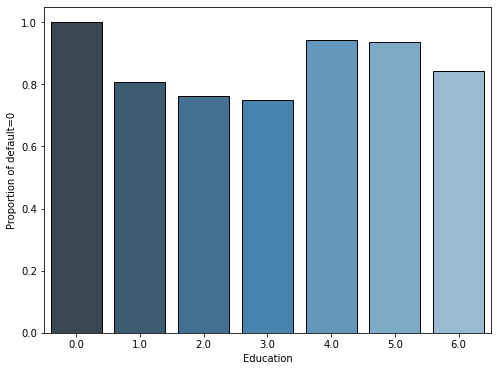

In [22]:
plt.figure(figsize=(8,6))
sns.barplot(x=ed_prop[:,0], y=ed_prop[:,1], palette="Blues_d", edgecolor='k')
plt.xlabel('Education')
plt.ylabel('Proportion of default=0')
plt.show()

Заметим, что распределение не похоже на равномерное. Наибольшая доля вернувших кредитов у докторов, что вероятнее всего обуславливается маленьким числом докторов в выборке.  Наименьшая доля у выпускников школы. Посмотрим на ожидаемые значения. Для этого посчитаем среднее значение доли вернувших кредит среди различных ступеней образования. Эту оценку будем использовать для генерации ожидаемых значений.

In [23]:
prop_ed_mean = ed_prop[:, 1].mean()

# число людей, представленных в выборке, с соответствующей ступенью образования (индексы соответствуют значению 'EDUCATION')
num_ed = data['EDUCATION'].value_counts(sort=False).values

# Ожидаемые значения 
exp_freq = np.array([prop_ed_mean * num_ed[i] for i in range(7)])

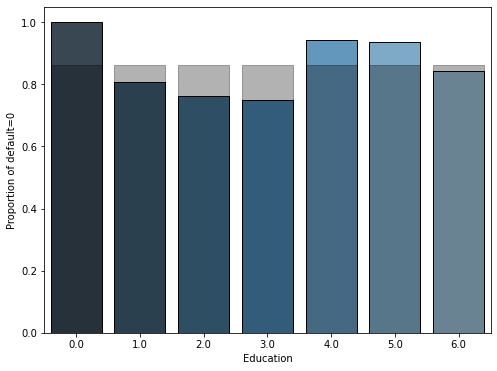

In [24]:
plt.figure(figsize=(8,6))
sns.barplot(x=ed_prop[:,0], y=ed_prop[:,1], palette="Blues_d", edgecolor='k')
sns.barplot(x=ed_prop[:,0], y=exp_freq/num_ed, color='black', alpha=0.3, edgecolor='k')
plt.xlabel('Education')
plt.ylabel('Proportion of default=0')
plt.show()

Разности между наблюдаемыми и ожидаемыми значениями в долях и значениях (индексы соответствуют значению 'EDUCATION'):

In [25]:
pd.DataFrame([ed_prop[:,1] - exp_freq/num_ed, np.around(obs_d0_ed-exp_freq)]).T.rename(columns = {0 : 'dif_prop', 1 : 'dif_num'})

,dif_prop,dif_num
0,0.137047,2.0
1,-0.055300,-585.0
2,-0.100301,-1407.0
3,-0.114529,-563.0
4,0.080137,10.0
5,0.072762,20.0
6,-0.019815,-1.0


Проверим это различие с помощью критерия Пирсона:

Нулевая гипотеза H0: рассматриваемый признак имеет равномерное распределение.

Альтернативная гипотеза H1: H0 не верна.

Условие применимости критерия, что наблюдаемые и ожидаемые значения должны быть не меньше 5. У нас данное условие выполненно:

In [44]:
obs_d0_ed

array([   14.,  8549., 10700.,  3680.,   116.,   262.,    43.])

In [26]:
print(obs_d0_ed>=5)
print(exp_freq>=5)

[ True  True  True  True  True  True  True]
[ True  True  True  True  True  True  True]


In [27]:
stats.chisquare(obs_d0_ed, exp_freq, ddof = 1)

Power_divergenceResult(statistic=278.7725391716089, pvalue=3.653181595163598e-58)

Значение pvalue чрезвычайно мало, тем самым на уровне значимости 0.001 мы уверенно отвергаем нулевую гипотезу о том, что признак имеет равномерное распределение. Это означает, что ступень образования как то влияет на то, вернет ли человек долг.

Поскольку число людей сгруппированных по признаку 'EDUCATION' сильно отличается, трудно говорить о том, какой признак является лучшим индикатором, что человек отдаст долг. Вполне возможно, у нас недостаточно данных по определенным группам. Однако, если рассматривать данную выборку, то доктора (группа 0) чаще отдают долг (а именно, в 100% случаев), а выпускники школ и люди с начальным образованием (группа 2 и 3) реже всех. Различие практичиски значимые, поскольку разница с ожидаемыми значениями достигает порядка 10%. 

### Признак MARRIAGE

In [28]:
print(data['MARRIAGE'].value_counts())

2    15964
1    13659
3      323
0       54
Name: MARRIAGE, dtype: int64


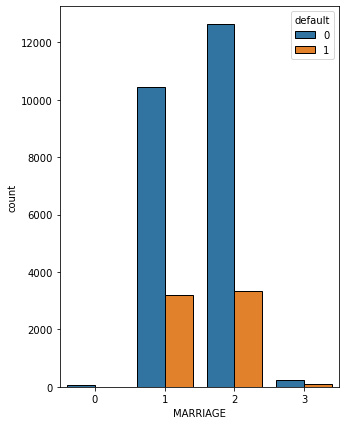

In [29]:
plt.figure(figsize=(5,7))
sns.countplot(x=data['MARRIAGE'], hue=data['default'], edgecolor='k')
plt.show()

Построим таблицу сопряженности.

In [30]:
mar_d0 = data[data['default'] == 0]['MARRIAGE']
mar_d1 = data[data['default'] == 1]['MARRIAGE']

cont_table = np.empty((len(data['MARRIAGE'].value_counts()), 2))

for i in range(len(data['MARRIAGE'].value_counts())):
    cont_table[i, 0] = len(mar_d0.loc[mar_d0 == i])
    cont_table [i, 1] = len(mar_d1.loc[mar_d1 == i])

In [31]:
cont_table

array([[4.9000e+01, 5.0000e+00],
       [1.0453e+04, 3.2060e+03],
       [1.2623e+04, 3.3410e+03],
       [2.3900e+02, 8.4000e+01]])

Проверим критерием Пирсона гипотезу о связи признака "MARRIAGE" c "default", используя таблицу сопряженности. 

Нулевая гипотеза H0: признак "MARRIAGE" не влияет на признак "default"

Альтернативная гипотеза H1: H0 не верна, т.е. признаки как то взаимосвязаны. 

In [32]:
stats.chi2_contingency(cont_table)

(35.66239583433609,
 8.825862457577375e-08,
 3,
 array([[4.20552000e+01, 1.19448000e+01],
        [1.06376292e+04, 3.02137080e+03],
        [1.24327632e+04, 3.53123680e+03],
        [2.51552400e+02, 7.14476000e+01]]))

Значение pvalue чрезвычайно мало, тем самым на уровне значимости 0.001 мы уверенно отвергаем нулевую гипотезу об отсутствии взаимосвязи у признаков. Тем не менее мы не знаем точно в какой из групп обнаруженна эта связь. Вполне возможно, что связь обусловлена несбалансированой выборкой по группам.  Для того чтобы измерить возможную взаимосвязь, можно также посчитать коэффициент Краммера.

In [33]:
def cramers_stat(confusion_matrix):
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    return np.sqrt(chi2 / (n*(min(confusion_matrix.shape)-1)))

In [34]:
print('Коэфициент Краммера: ',cramers_stat(cont_table))

Коэфициент Краммера:  0.034478203662766466


Чем ближе значение коэфициента Краммера к нулю, тем больше это говорит об отсутствии взаимосвязи между признаками. Таким образом, не смотря на то, что мы отвергли нулевую гипотезу об отсутствии взаимосвязи, коэфициент Краммера показывает, что зависимость незначительная.

### Признак AGE

Будем применять тот же подходит, что и с признаком "LIMIT_BALL". Для начала посмотрим на распределение признака:

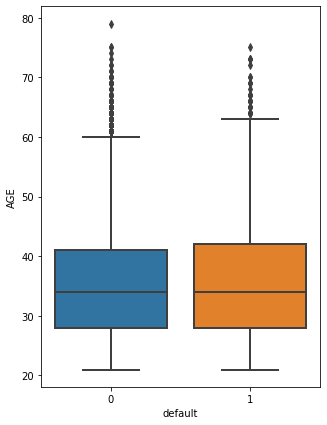

In [35]:
plt.figure(figsize=(5,7))
sns.boxplot(x=data['default'], y=data['AGE'], linewidth=2)
plt.show()

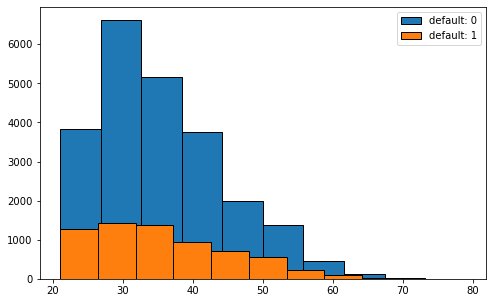

In [36]:
plt.figure(figsize=(8,5))
plt.hist(data[data['default'] == 0]['AGE'], label='default: 0', edgecolor='k')
plt.hist(data[data['default'] == 1]['AGE'], label='default: 1', edgecolor='k', color='tab:orange')
plt.legend()
plt.show()

Построим доверительные интервалы для медиан с помощью бутстрепа:

In [37]:
no_def_age = data[data['default'] == 0]['AGE'].values
with_def_age = data[data['default'] == 1]['AGE'].values

np.random.seed(0)

no_def_age_scores = list(map(np.median, get_bootstrap_samples(no_def_age, 1000)))
with_def_age_scores = list(map(np.median, get_bootstrap_samples(with_def_age, 1000)))

In [38]:
print('95% доверительный интервал для медианы выборки с default 0: ', stat_intervals(no_def_age_scores, 0.05))
print('95% доверительный интервал для медианы выборки с default 1: ', stat_intervals(with_def_age_scores, 0.05))

95% доверительный интервал для медианы выборки с default 0:  [34. 34.]
95% доверительный интервал для медианы выборки с default 1:  [34. 35.]


In [39]:
delta_median_scores_age = list(map(lambda x: x[0] - x[1], zip(no_def_age_scores, with_def_age_scores)))
print('95% доверительный интервал для разности медиан: ',  stat_intervals(delta_median_scores_age, 0.05))

95% доверительный интервал для разности медиан:  [-1.  0.]


Видим, что доверительные интервалы для медиан пересекаются, а также доверительный интервал для разности медиан содержит ноль. Все это говорит о том, что мы не может отвергнуть нулевую гипотезу о совпадении медиан. 

Проверим гипотезу о равенстве распределений с помощью непараметрического критерия Манни-Уитни:

H0: распределения выборок полностью равны,
H1: распределения выборок отличаются на величину сдвига.

In [118]:
stats.mannwhitneyu(no_def_age, with_def_age)

MannwhitneyuResult(statistic=76966879.5, pvalue=0.1862517717449308)

Значение pvalue > 0.05, т.е. мы не может отклонить нулевую гипотезу на уровне значимости 0.05. Таким образом, мы не можем утверждать, что возвращение долга как либо зависит от возраста.